In [1]:
# Lasciate questa cella così ogni volta che aggiornate un file python, 
# anche gli import nel notebook vengono aggiornati

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

from Utils import *
from constants import *

from Environment import *
from Non_Stationary_Environment import *

from Social_influence import *
from Network import Network

from Simulation import *

from Ecommerce import *
from Ecommerce3 import *
from Ecommerce4 import *
from Ecommerce5 import *
from Ecommerce6 import *

In [3]:
simulate_step3()


n_experiment:   0%|          | 0/2 [00:00<?, ?it/s]

[[8.17801615e-02 0.00000000e+00 3.25187110e-02 8.96941109e-06
  1.21364743e-19]
 [6.58041267e-02 8.60953426e-05 4.76728373e-02 1.04685566e-06
  9.98485857e-05]
 [2.56593623e-02 4.00552850e-14 2.80653672e-02 4.16337294e-09
  4.29037483e-09]]
[[4.09547563e-09 0.00000000e+00 6.51765687e-07 5.07229060e-02
  3.65378941e-02]
 [2.15016416e-06 2.78472303e-05 2.28934604e-23 3.66863660e-02
  1.94992799e-02]
 [7.57401038e-04 3.14235186e-09 9.83299878e-07 5.78806989e-02
  2.15908874e-02]]
[[8.17801615e-02 0.00000000e+00 3.25187110e-02 3.56251494e-02
  6.12484272e-03]
 [6.58041267e-02 5.76022173e-03 7.67491651e-02 2.32552583e-02
  2.18381354e-12]
 [2.56593623e-02 6.72648916e-04 3.12740732e-02 3.30840947e-02
  2.02945219e-19]]
[[8.17801615e-02 0.00000000e+00 3.25187110e-02 3.97356814e-02
  1.73565505e-05]
 [6.58041267e-02 3.09629423e-05 6.56774142e-02 2.69146222e-02
  6.76575359e-04]
 [2.56593623e-02 7.24906220e-10 3.12740732e-02 2.44005124e-02
  2.20619811e-03]]
[[6.09955551e-10 0.00000000e+00 3.25

[[1.49450017e-11 0.00000000e+00 3.25187110e-02 7.95533626e-02
  8.22327649e-06]
 [9.40019998e-05 1.80885777e-09 7.67491651e-02 3.66863660e-02
  3.65879353e-03]
 [2.64397450e-04 1.26586893e-03 3.12740732e-02 5.26061830e-02
  5.06350627e-10]]


[[9.89436942e-04 0.00000000e+00 3.25187110e-02 5.75842021e-02
  2.87705257e-03]
 [6.05139510e-10 8.11328746e-10 7.67491651e-02 3.66863660e-02
  1.04802542e-12]
 [4.26285543e-05 1.66210008e-08 3.12740732e-02 6.07341740e-02
  2.71924375e-03]]
[[3.79751848e-02 0.00000000e+00 1.43273021e-08 3.04885227e-06
  1.05536814e-09]
 [3.79576201e-02 5.43094848e-09 1.12037415e-04 8.05381594e-05
  2.47093048e-03]
 [2.56593623e-02 1.61017572e-03 2.08703722e-07 5.38261821e-08
  3.71162723e-07]]


[[2.98951232e-02 0.00000000e+00 3.25187110e-02 2.89799621e-02
  1.24305214e-04]
 [2.81931188e-02 7.08381629e-08 7.67491651e-02 2.98547325e-02
  3.28145671e-04]
 [1.44704320e-02 3.35541539e-05 3.12740732e-02 3.22394706e-02
  3.59753186e-05]]
[[1.73439679e-03 0.00000000e+00 7.67810037e-04 8.67583259e-05
  1.19366930e-09]
 [6.51705970e-07 3.06127193e-09 4.12872185e-06 4.88293455e-06
  2.15265901e-07]
 [9.44546042e-04 6.78766758e-05 2.80496855e-03 1.16159481e-04
  1.73796973e-18]]


[[8.17801615e-02 0.00000000e+00 3.25187110e-02 8.35379945e-02
  1.68922195e-04]
 [6.58041267e-02 2.38303638e-09 2.08316085e-02 3.66863660e-02
  1.24288138e-05]
 [2.56593623e-02 5.44464411e-08 3.12740732e-02 6.72012003e-02
  2.07933063e-29]]
[[2.51506847e-05 0.00000000e+00 3.25187110e-02 5.75679259e-13
  1.51879369e-04]
 [2.23964714e-26 6.19334289e-18 1.92263204e-02 1.21735633e-04
  2.92878707e-04]
 [2.94491137e-04 6.95812052e-14 3.12740732e-02 2.61373984e-06
  1.46003276e-06]]


[[8.17801615e-02 0.00000000e+00 3.35822905e-04 5.22246146e-02
  6.17654543e-05]
 [6.58041267e-02 1.99271949e-07 2.93656512e-06 3.66863660e-02
  2.25642393e-03]
 [2.56593623e-02 2.08097473e-04 7.35444455e-09 6.72012003e-02
  2.90106164e-05]]
[[1.10319966e-10 0.00000000e+00 4.16652440e-04 3.03834228e-02
  1.82687192e-04]
 [7.26186124e-05 5.21284577e-05 1.85947201e-05 3.66863660e-02
  8.27045575e-14]
 [1.14787257e-07 6.15380984e-05 1.34051356e-05 3.37817006e-02
  8.63180774e-04]]


[[1.35714608e-07 0.00000000e+00 5.31749005e-08 8.35379945e-02
  2.41056041e-12]
 [3.83863958e-03 1.83947345e-03 3.38428663e-04 3.66863660e-02
  2.49101175e-04]
 [3.88292449e-04 5.88080167e-07 1.52752063e-09 6.72012003e-02
  3.94454590e-09]]
[[2.59423499e-11 0.00000000e+00 1.22533733e-06 1.09331475e-04
  8.72985214e-08]
 [2.38012138e-23 9.83560697e-04 9.52688080e-05 3.18895344e-05
  5.42348171e-06]
 [1.60401599e-03 6.18652701e-13 7.27692089e-22 1.06830325e-13
  4.72438954e-22]]


[[8.17801615e-02 0.00000000e+00 3.25187110e-02 3.15453962e-02
  2.01593349e-04]
 [6.58041267e-02 1.80904860e-13 7.67491651e-02 1.90645829e-02
  2.39977045e-04]
 [2.56593623e-02 2.47030884e-09 3.12740732e-02 2.98912315e-02
  2.99398206e-06]]
[[8.17801615e-02 0.00000000e+00 1.32285591e-11 2.80524071e-06
  2.21178176e-08]
 [6.08813144e-02 4.14915874e-05 1.88315706e-06 1.11358991e-11
  7.77705756e-09]
 [2.56593623e-02 1.04733793e-08 1.88622453e-08 8.04276118e-05
  3.14618492e-08]]


[[8.17801615e-02 0.00000000e+00 5.58703788e-07 6.61741903e-05
  1.03495145e-06]
 [6.58041267e-02 6.98726209e-13 2.67586664e-10 4.11407868e-11
  4.52699327e-08]
 [2.56593623e-02 9.51407972e-09 8.66614970e-08 2.59287423e-06
  5.51730362e-04]]
[[1.14261453e-05 0.00000000e+00 1.95830032e-10 1.76271601e-04
  7.05583753e-06]
 [2.14522298e-03 2.02007118e-02 4.18798174e-04 2.00802240e-05
  1.12885329e-10]
 [2.10103900e-09 1.78725204e-02 3.34791839e-04 8.44881148e-08
  1.02546226e-03]]


[[6.05796833e-02 0.00000000e+00 3.25187110e-02 5.76645985e-06
  3.85057230e-03]
 [6.58041267e-02 5.66974758e-05 7.67491651e-02 7.18121255e-07
  1.37127646e-02]
 [2.56593623e-02 1.38130148e-04 3.12740732e-02 2.83420914e-09
  4.87020577e-03]]
[[1.51734837e-12 0.00000000e+00 3.25187110e-02 8.46916843e-04
  5.11687191e-11]
 [4.27471228e-13 1.03920846e-08 7.02126608e-02 2.79462633e-06
  2.65732983e-03]
 [1.52660505e-03 1.19719076e-05 3.12740732e-02 3.50163228e-06
  3.89615229e-07]]


[[2.73292683e-02 0.00000000e+00 3.25187110e-02 6.84128053e-02
  2.26895442e-07]
 [2.18043552e-02 3.62548015e-14 7.67491651e-02 3.66863660e-02
  7.56684779e-06]
 [2.56433307e-02 2.41383153e-06 3.12740732e-02 6.72012003e-02
  1.31647210e-29]]
[[2.03452087e-09 0.00000000e+00 1.43931801e-05 5.74170044e-02
  7.50464659e-11]
 [4.22023320e-08 9.98582297e-09 5.03994261e-04 3.66863660e-02
  3.66331186e-03]
 [9.01158157e-06 7.95606995e-05 1.20504341e-04 5.39195259e-02
  2.33980317e-06]]


[[8.17801615e-02 0.00000000e+00 1.35445435e-05 6.90908260e-02
  1.95387437e-08]
 [6.58041267e-02 3.40136386e-07 2.07851890e-04 3.66863660e-02
  6.31869437e-03]
 [2.56593623e-02 3.15800336e-06 2.24633359e-03 6.72012003e-02
  5.84592719e-04]]
[[2.57924727e-10 0.00000000e+00 1.94975199e-03 4.15899552e-04
  1.58771648e-08]
 [4.75667962e-03 2.66159379e-05 4.30593999e-18 1.19959047e-09
  1.02705832e-03]
 [3.73745542e-05 2.08798086e-18 4.54972709e-08 2.91329141e-10
  9.49572824e-07]]


[[4.48952404e-02 0.00000000e+00 3.25187110e-02 4.96360836e-02
  4.32224780e-10]
 [4.24782281e-02 4.09411531e-02 7.67491651e-02 3.66863660e-02
  3.23009476e-05]
 [2.50215841e-02 3.41107926e-02 3.12740732e-02 2.22419434e-02
  1.45446997e-03]]
[[8.17801615e-02 0.00000000e+00 5.74830602e-20 6.79235321e-08
  1.63529716e-08]
 [6.58041267e-02 3.87157515e-08 5.73134904e-06 2.70673709e-08
  3.82691774e-05]
 [2.56593623e-02 1.10172338e-03 4.57821259e-13 4.42468958e-13
  8.01651278e-08]]


[[8.17801615e-02 0.00000000e+00 4.60723412e-05 8.35379945e-02
  1.31309950e-03]
 [6.58041267e-02 8.70792002e-06 7.32086262e-11 3.66863660e-02
  8.56517900e-09]
 [2.56593623e-02 1.92233545e-09 6.60078366e-06 6.72012003e-02
  1.41606682e-06]]
[[4.82282030e-07 0.00000000e+00 1.19521301e-06 2.13034672e-15
  2.28475453e-05]
 [2.02547982e-23 2.78036134e-02 2.70034037e-25 2.24025767e-07
  1.14153919e-04]
 [5.11138645e-07 4.04634776e-02 1.83587807e-07 2.01025555e-06
  2.17203353e-11]]


[[8.17801615e-02 0.00000000e+00 4.41176468e-11 1.14225606e-03
  1.59661003e-04]
 [6.58041267e-02 4.70663979e-12 3.35614372e-04 1.62948380e-07
  5.75656030e-04]
 [2.56593623e-02 9.84080711e-04 7.09603104e-05 9.21302027e-08
  2.21659641e-06]]
[[6.90326772e-05 0.00000000e+00 3.25187110e-02 1.51163504e-04
  1.56024960e-04]
 [1.24420809e-07 5.71797140e-06 7.67491651e-02 4.71692669e-06
  1.54170606e-07]
 [1.03892708e-05 1.56466123e-14 3.12740732e-02 9.02432253e-05
  6.17115096e-21]]


[[8.17801615e-02 0.00000000e+00 3.08492341e-02 6.06976862e-02
  8.21628975e-05]
 [6.58041267e-02 1.93027001e-02 2.06870577e-02 3.66863660e-02
  1.06871877e-05]
 [2.56593623e-02 7.81766426e-03 3.12740732e-02 5.28842984e-02
  2.62202769e-04]]
[[1.44927852e-11 0.00000000e+00 3.63250053e-15 7.95323014e-02
  4.10513119e-09]
 [1.37173741e-06 5.99119242e-08 7.65197861e-04 3.66863660e-02
  1.09999578e-05]
 [1.55546344e-05 1.53260157e-03 7.42519453e-07 6.72012003e-02
  5.80099770e-16]]


[[8.17801615e-02 0.00000000e+00 9.59433465e-10 8.35379945e-02
  2.71988577e-08]
 [6.58041267e-02 4.83715038e-04 1.77776995e-11 3.66863660e-02
  1.82896455e-04]
 [2.56593623e-02 9.17697657e-04 1.17185933e-07 6.72012003e-02
  3.65202823e-13]]
[[6.38270640e-07 0.00000000e+00 9.87945205e-32 5.48995517e-10
  9.13233529e-06]
 [6.44086609e-04 1.76352487e-05 1.65455040e-05 3.15321031e-07
  7.60258062e-06]
 [1.18972131e-13 4.82643363e-12 5.25787374e-04 2.74566243e-09
  2.06728086e-03]]


[[8.17801615e-02 0.00000000e+00 6.31911935e-04 4.83273709e-02
  5.41192119e-16]
 [6.58041267e-02 5.72394266e-25 7.18182581e-06 2.95669168e-02
  2.53849730e-07]
 [2.56593623e-02 3.66207169e-17 1.00932792e-07 3.31485954e-02
  7.87418953e-05]]
[[8.17801615e-02 0.00000000e+00 8.31925272e-05 2.78726307e-07
  2.11726055e-07]
 [6.58041267e-02 1.49377704e-04 3.64541208e-11 1.06414053e-09
  9.44149442e-03]
 [2.56593623e-02 4.40974517e-11 1.43905970e-06 8.69183004e-10
  3.99446442e-10]]


[[8.17801615e-02 0.00000000e+00 1.04936983e-03 2.21536420e-02
  4.15335423e-04]
 [6.58041267e-02 1.74075862e-05 1.19295776e-06 2.31517487e-02
  1.92045129e-08]
 [2.56593623e-02 9.43184587e-15 3.64923980e-10 4.68869379e-02
  3.78364880e-03]]
[[4.90577162e-10 0.00000000e+00 1.02907141e-04 5.02253244e-11
  4.05053200e-07]
 [1.00248021e-03 4.88759289e-02 7.41966938e-05 4.71069944e-11
  1.55384865e-05]
 [1.51106145e-08 4.07824214e-02 2.95234039e-05 3.50692981e-04
  5.87934875e-08]]


[[3.45084133e-02 0.00000000e+00 4.07706846e-06 8.35379945e-02
  1.04665821e-05]
 [3.04340179e-02 6.02205851e-04 7.27490250e-05 3.66863660e-02
  1.44069223e-02]
 [2.01574745e-02 3.90562408e-05 4.16845620e-04 6.72012003e-02
  3.85311304e-12]]
[[4.67508360e-10 0.00000000e+00 3.25187110e-02 8.50797520e-15
  4.72763159e-08]
 [2.92552792e-05 5.87781164e-06 7.67491651e-02 6.94723696e-06
  1.80553027e-12]
 [6.56886463e-05 6.79744573e-21 3.12740732e-02 7.48249330e-06
  4.12040664e-04]]


[[9.15044044e-14 0.00000000e+00 3.25187110e-02 8.35379945e-02
  8.92151119e-07]
 [7.66872116e-09 2.24909213e-03 7.67491651e-02 3.66863660e-02
  1.07446475e-05]
 [1.05208731e-06 1.42831092e-03 3.12740732e-02 6.72012003e-02
  3.22682352e-10]]
[[7.55860430e-05 0.00000000e+00 5.86181184e-04 8.35379945e-02
  1.63001855e-10]
 [1.54551484e-07 2.34830561e-15 5.77905615e-24 3.66863660e-02
  3.98871621e-10]
 [3.94411390e-03 2.28534522e-08 1.26926421e-06 6.72012003e-02
  4.81568125e-07]]


n_experiment:  50%|█████     | 1/2 [00:18<00:18, 18.24s/it]

[[7.56544539e-02 6.13723497e-05 3.56711042e-02 8.96941109e-06
  1.21364743e-19]
 [5.46659549e-02 8.60953426e-05 4.76728373e-02 1.04685566e-06
  9.98485857e-05]
 [8.20686496e-02 4.00552850e-14 2.80653672e-02 4.16337294e-09
  4.29037483e-09]]
[[4.09547563e-09 4.57826054e-10 6.51765687e-07 5.07229060e-02
  1.81464319e-02]
 [2.15016416e-06 2.78472303e-05 2.28934604e-23 3.79281520e-02
  1.94992799e-02]
 [7.57401038e-04 3.14235186e-09 9.83299878e-07 5.78806989e-02
  2.15908874e-02]]
[[7.56544539e-02 5.94223393e-05 8.87924638e-02 3.56251494e-02
  6.12484272e-03]
 [5.46659549e-02 5.76022173e-03 6.14440520e-02 2.32552583e-02
  2.18381354e-12]
 [8.20686496e-02 6.72648916e-04 5.83876062e-02 3.30840947e-02
  2.02945219e-19]]
[[7.56544539e-02 1.17977353e-11 7.97920588e-02 3.97356814e-02
  1.73565505e-05]
 [5.46659549e-02 3.09629423e-05 6.14440520e-02 2.69146222e-02
  6.76575359e-04]
 [8.20686496e-02 7.24906220e-10 5.83876062e-02 2.44005124e-02
  2.20619811e-03]]
[[6.09955551e-10 3.07029327e-04 8.87

[[7.56544539e-02 2.77381612e-15 3.76309506e-08 1.08848645e-01
  3.98735874e-04]
 [5.46659549e-02 1.80885777e-09 2.99305527e-07 3.79281520e-02
  1.89570236e-11]
 [8.20686496e-02 1.26586893e-03 3.06348972e-04 6.69667007e-02
  7.27044728e-07]]


[[7.56544539e-02 1.31236608e-02 5.54460587e-02 7.62794262e-02
  8.28916175e-04]
 [5.46659549e-02 4.44023655e-02 5.14744393e-02 3.79281520e-02
  8.25223730e-32]
 [5.89832539e-02 3.40299851e-02 5.83876062e-02 6.69667007e-02
  7.93881877e-04]]
[[3.79751848e-02 1.15790426e-12 1.43273021e-08 3.04885227e-06
  1.05536814e-09]
 [3.79576201e-02 5.43094848e-09 1.12037415e-04 8.05381594e-05
  2.47093048e-03]
 [4.09209800e-02 1.61017572e-03 2.08703722e-07 5.38261821e-08
  3.71162723e-07]]


[[3.84964885e-05 1.31236608e-02 8.87924638e-02 1.59587150e-12
  3.06760733e-04]
 [2.12574827e-04 4.19502994e-02 6.14440520e-02 5.49861175e-04
  3.40805822e-09]
 [7.95361741e-05 2.49155772e-02 5.83876062e-02 6.03739857e-05
  1.59948954e-05]]
[[3.39506873e-07 1.81250976e-05 7.67810037e-04 8.67583259e-05
  1.19366930e-09]
 [1.43358273e-03 3.06127193e-09 4.12872185e-06 4.88293455e-06
  2.15265901e-07]
 [6.77391916e-04 6.78766758e-05 2.80496855e-03 1.16159481e-04
  1.73796973e-18]]


[[2.38615218e-02 1.31236608e-02 7.23880890e-02 2.78283478e-02
  1.68922195e-04]
 [3.24737960e-02 5.59552103e-02 4.99113550e-02 3.79281520e-02
  1.24288138e-05]
 [4.35241105e-02 5.14307444e-02 5.83876062e-02 4.17107366e-02
  2.07933063e-29]]
[[2.51506847e-05 5.77056295e-09 4.06403049e-02 5.75679259e-13
  1.51879369e-04]
 [2.23964714e-26 6.19334289e-18 1.92263204e-02 1.21735633e-04
  2.92878707e-04]
 [2.94491137e-04 6.95812052e-14 4.32428415e-02 2.61373984e-06
  1.46003276e-06]]


[[2.38180857e-04 1.31236608e-02 7.81703394e-02 1.51141285e-06
  1.25781437e-06]
 [1.86868198e-04 5.59552103e-02 6.14440520e-02 2.99012837e-05
  2.90265758e-05]
 [2.44766837e-19 5.14307444e-02 5.83876062e-02 5.18203608e-07
  1.50408219e-04]]
[[1.82059534e-10 7.67862502e-06 3.34922917e-07 4.67711359e-02
  8.04177095e-09]
 [2.13512446e-11 2.08592631e-08 8.70264105e-08 1.89148878e-02
  5.97813136e-21]
 [5.05666979e-12 6.51946381e-04 2.06700727e-10 2.63694810e-02
  3.38237627e-07]]


[[6.64014259e-02 6.40095664e-23 8.09814998e-02 9.40086875e-02
  2.41056041e-12]
 [5.46659549e-02 3.47493396e-09 6.14440520e-02 3.79281520e-02
  2.49101175e-04]
 [7.81827312e-02 1.12202383e-13 5.83876062e-02 6.69667007e-02
  3.94454590e-09]]
[[2.59423499e-11 4.38248503e-09 1.22533733e-06 1.09331475e-04
  8.72985214e-08]
 [2.38012138e-23 9.83560697e-04 9.52688080e-05 3.18895344e-05
  5.42348171e-06]
 [1.60401599e-03 6.18652701e-13 7.27692089e-22 1.06830325e-13
  4.72438954e-22]]


[[4.46059844e-02 1.19841814e-07 8.87924638e-02 3.12440607e-05
  2.15684278e-04]
 [2.53462735e-02 1.80904860e-13 6.14440520e-02 2.79739134e-10
  2.55838357e-04]
 [4.36060957e-02 2.47030884e-09 5.83876062e-02 3.25243138e-07
  3.55877293e-06]]
[[7.56544539e-02 4.15056911e-06 1.32285591e-11 2.80524071e-06
  2.21178176e-08]
 [5.46659549e-02 4.14915874e-05 1.88315706e-06 1.11358991e-11
  7.77705756e-09]
 [8.20686496e-02 1.04733793e-08 1.88622453e-08 8.04276118e-05
  3.14618492e-08]]


[[4.06392227e-10 3.74929059e-07 8.87924638e-02 6.61741903e-05
  4.07083009e-08]
 [5.36276523e-08 6.98726209e-13 6.14440520e-02 4.11407868e-11
  5.59131708e-10]
 [2.34209786e-05 9.51407972e-09 5.83876062e-02 2.59287423e-06
  2.66058133e-04]]
[[1.14261453e-05 9.51771026e-03 1.95830032e-10 1.76271601e-04
  7.05583753e-06]
 [2.14522298e-03 2.02007118e-02 4.18798174e-04 2.00802240e-05
  1.12885329e-10]
 [2.10103900e-09 1.78725204e-02 3.34791839e-04 8.44881148e-08
  1.02546226e-03]]


[[1.61718713e-08 8.70339090e-08 7.68235240e-02 5.77004757e-02
  3.85057230e-03]
 [1.54149536e-05 2.61434611e-09 6.14440520e-02 3.79281520e-02
  1.37127646e-02]
 [1.70736975e-04 6.33286363e-11 5.83876062e-02 5.25437620e-02
  4.87020577e-03]]
[[1.51734837e-12 3.23722968e-06 4.55227463e-02 8.46916843e-04
  5.11687191e-11]
 [4.27471228e-13 1.03920846e-08 6.14440520e-02 2.79462633e-06
  2.65732983e-03]
 [1.52660505e-03 1.19719076e-05 5.57128719e-02 3.50163228e-06
  3.89615229e-07]]


[[7.56544539e-02 2.80965270e-08 7.34968765e-05 1.10233822e-01
  2.26895442e-07]
 [5.46659549e-02 3.62548015e-14 1.73442735e-12 3.79281520e-02
  7.56684779e-06]
 [8.20686496e-02 2.41383153e-06 6.31312378e-04 6.69667007e-02
  1.31647210e-29]]
[[2.03452087e-09 3.26897724e-08 1.43931801e-05 5.74170044e-02
  7.50464659e-11]
 [4.22023320e-08 9.98582297e-09 5.03994261e-04 3.79281520e-02
  3.66331186e-03]
 [9.01158157e-06 7.95606995e-05 1.20504341e-04 5.39195259e-02
  2.33980317e-06]]


[[7.56544539e-02 1.31236608e-02 3.85891308e-02 9.61881052e-09
  1.10753403e-05]
 [5.46659549e-02 5.59552103e-02 2.29142049e-02 1.75402219e-03
  1.46198209e-07]
 [8.20686496e-02 4.75153132e-02 3.00458664e-02 1.86728889e-17
  5.22923601e-06]]
[[3.01846211e-15 3.73745542e-05 2.08798086e-18 4.54972709e-08
  2.93120531e-08]
 [3.43019444e-06 6.92168624e-14 1.94975199e-03 4.15899552e-04
  1.58771648e-08]
 [4.75667962e-03 2.66159379e-05 4.30593999e-18 1.19959047e-09
  1.02705832e-03]]


[[7.56544539e-02 1.59769561e-10 8.87924638e-02 3.33096039e-06
  6.87748504e-05]
 [5.46659549e-02 2.55675943e-04 6.14440520e-02 2.75581531e-05
  3.99285790e-08]
 [8.20686496e-02 1.05778532e-12 5.83876062e-02 1.07871257e-07
  1.22213907e-04]]
[[7.56544539e-02 1.83395141e-03 1.10172338e-03 4.57821259e-13
  4.42468958e-13]
 [5.46659549e-02 9.88521232e-05 5.74830602e-20 6.79235321e-08
  1.63529716e-08]
 [7.88394023e-02 3.87157515e-08 5.73134904e-06 2.70673709e-08
  3.82691774e-05]]


[[4.57330419e-02 1.16535167e-12 6.10998014e-02 3.37391594e-02
  3.48054833e-03]
 [5.46659549e-02 1.72669840e-16 2.68606467e-02 3.79281520e-02
  4.11349670e-03]
 [7.94293457e-02 8.70792002e-06 3.43525486e-02 3.67348658e-02
  4.36951388e-05]]
[[1.41606682e-06 1.31236608e-02 9.52946098e-07 1.83587807e-07
  2.01025555e-06]
 [4.82282030e-07 2.83841620e-02 1.19521301e-06 2.13034672e-15
  2.28475453e-05]
 [2.02547982e-23 2.78036134e-02 2.70034037e-25 2.24025767e-07
  1.14153919e-04]]


[[3.45642033e-02 5.38939472e-09 8.87924638e-02 2.38817262e-02
  2.72101164e-06]
 [5.03582500e-02 1.37566574e-08 6.14440520e-02 3.56228727e-02
  1.73702620e-05]
 [3.62823178e-02 4.70663979e-12 5.83876062e-02 3.60616505e-02
  3.24013112e-03]]
[[4.16664757e-06 1.59197287e-03 8.87924638e-02 7.23759594e-18
  2.57190769e-11]
 [6.29411565e-12 1.98439827e-08 6.14440520e-02 1.19784687e-10
  4.92007701e-06]
 [2.65843721e-08 1.30880300e-26 5.83876062e-02 1.51720236e-09
  1.63749106e-04]]


[[5.79737218e-02 1.31236608e-02 2.96707639e-02 1.29850355e-05
  1.31753143e-14]
 [4.54464503e-02 5.59552103e-02 4.08318164e-02 3.84288158e-12
  3.10075121e-10]
 [8.11188934e-02 5.14307444e-02 4.99765070e-02 1.08081735e-05
  6.09830525e-04]]
[[1.47857059e-04 3.06447619e-10 3.68059240e-10 1.03501916e-01
  2.95826284e-10]
 [7.00642325e-09 3.33146433e-07 1.46400399e-06 3.79281520e-02
  1.04021961e-21]
 [4.33271293e-08 3.77758370e-05 1.40768425e-06 6.69667007e-02
  1.04199788e-09]]


[[4.10513119e-09 1.31236608e-02 8.87924638e-02 9.59433465e-10
  3.04226935e-08]
 [1.09999578e-05 4.06903661e-02 6.14440520e-02 1.77776995e-11
  1.80767973e-12]
 [5.80099770e-16 5.14307444e-02 5.83876062e-02 1.17185933e-07
  2.52760464e-13]]
[[2.02282792e-08 6.38270640e-07 7.54793948e-11 9.87945205e-32
  1.93592789e-05]
 [1.69964635e-04 6.44086609e-04 1.76352487e-05 1.65455040e-05
  1.68962870e-04]
 [2.05343787e-13 1.18972131e-13 4.82643363e-12 5.25787374e-04
  3.44392061e-05]]


[[7.56544539e-02 1.31236608e-02 4.08774019e-02 5.00461467e-02
  1.92496894e-05]
 [5.46659549e-02 3.20548844e-02 3.06505205e-02 3.74230376e-02
  3.68397162e-08]
 [8.20686496e-02 5.07755627e-02 3.97845354e-02 2.18342874e-02
  5.98870603e-15]]
[[7.56544539e-02 2.61787607e-03 5.95829182e-06 8.31925272e-05
  2.78726307e-07]
 [5.46659549e-02 4.01491898e-09 1.49377704e-04 3.64541208e-11
  1.06414053e-09]
 [8.20686496e-02 8.65740922e-07 4.40974517e-11 1.43905970e-06
  8.69183004e-10]]


[[6.41007766e-02 1.45744296e-07 8.87924638e-02 3.62027544e-11
  1.24353101e-13]
 [5.46659549e-02 1.64930673e-18 6.14440520e-02 8.88457516e-06
  1.33413060e-05]
 [3.30229318e-02 5.01312057e-08 5.83876062e-02 1.72347504e-04
  3.91173645e-06]]
[[7.35713325e-07 1.31236608e-02 6.15719422e-11 9.88316179e-08
  1.98951820e-21]
 [1.42393185e-08 5.27120709e-02 5.43009605e-04 2.15768377e-07
  6.23644133e-07]
 [3.33967810e-09 5.14307444e-02 6.83374594e-09 1.11053347e-03
  1.06397942e-04]]


[[2.90953546e-02 2.08730793e-05 8.87924638e-02 9.84630034e-02
  3.41445653e-05]
 [4.96582354e-02 3.89401597e-05 6.14440520e-02 3.79281520e-02
  8.67448764e-16]
 [3.35016709e-02 9.92228437e-07 5.83876062e-02 6.69667007e-02
  2.18043719e-06]]
[[1.99291306e-06 5.88499887e-05 8.87924638e-02 5.53233658e-06
  1.39599761e-09]
 [1.78231952e-09 2.74314919e-11 6.14440520e-02 8.64659860e-07
  1.74682512e-03]
 [2.12494977e-03 3.95954660e-04 5.83876062e-02 2.61784213e-04
  8.50797520e-15]]


[[7.56544539e-02 1.80553027e-12 7.66872116e-09 8.21893698e-02
  7.01947439e-04]
 [5.46659549e-02 4.12040664e-04 1.05208731e-06 3.79281520e-02
  9.15790469e-05]
 [8.20686496e-02 9.15044044e-14 1.24145472e-03 6.02176564e-02
  1.11794377e-17]]
[[1.68782298e-05 1.07446475e-05 1.54551484e-07 9.52959506e-02
  5.77905615e-24]
 [2.16952005e-09 3.22682352e-10 3.94411390e-03 3.79281520e-02
  1.26926421e-06]
 [8.92151119e-07 7.55860430e-05 3.44071357e-04 6.69667007e-02
  1.03975006e-05]]


n_experiment: 100%|██████████| 2/2 [00:36<00:00, 18.12s/it]


(array([[         nan,          nan,          nan,          nan,
                  nan,          nan,          nan,          nan,
                  nan,          nan,          nan,          nan,
                  nan,          nan,          nan,          nan,
                  nan,          nan,          nan,          nan],
        [299.98220677, 304.92314804,  84.43448785, 156.84259556,
          88.60299778, 338.34008221, 132.09145757,  73.78958964,
         116.24235121, 300.86056644, 246.79620133, 286.7350123 ,
         214.79521038, 181.22734657, 205.38791186,  89.98034509,
         276.41954085, 197.42897638, 227.78510748, 279.16695366]]),
 array([[           nan,            nan,            nan,            nan,
                    nan,            nan,            nan,            nan,
                    nan,            nan,            nan,            nan,
                    nan,            nan,            nan,            nan,
                    nan,            nan,            na

## Step 3

In [3]:
gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts = simulate_step3()

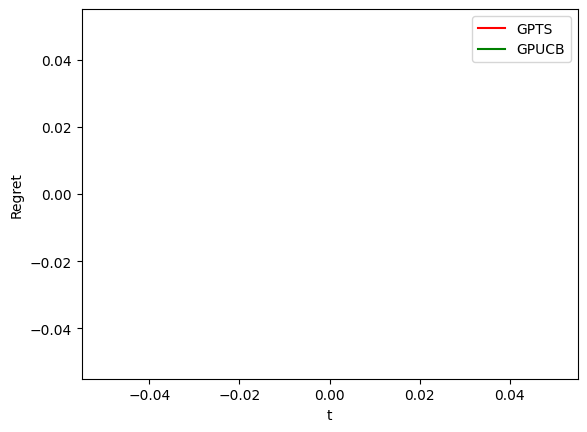

In [4]:
plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean((opts-gpts_rewards_per_experiment.T).T, axis = 0)), 'r')
plt.plot(np.cumsum(np.mean((opts-gpucb_rewards_per_experiment.T).T, axis = 0)), 'g')
plt.legend(["GPTS", "GPUCB"])
plt.show()

## Step 4

In [ ]:
gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts = simulate_step4()
plot_regrets_step4(gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts)

## Step 5

In [ ]:
gpucb_rewards_per_experiment, gpts_rewards_per_experiment, opts = simulate_step5()
plot_regrets_step5(gpts_rewards_per_experiment,gpucb_rewards_per_experiment,opts)

## Step 6

In [ ]:
swucb_rewards_per_experiment, cducb_rewards_per_experiment, opts = simulate_step6()
plot_regrets_step6(swucb_rewards_per_experiment,cducb_rewards_per_experiment, opts)